# Project GEVPRO (H&M) - Nils

We will work with the following dataset: 
Source: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview
This dataset has been reduced to use less memory. Only sales data from > 08-01-2020 is selected. 

In [1]:
# Used libaries:
%matplotlib inline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

### 0.  Research questions:
We try to answer the following main resear question:“What is the latest trend in fashion?” This main research question is devided into 3 sub categories: 
1. Sales
2. Customer base
3. Fashion reccomendation

### 1.  Reducing the dataset: 
This is only ran on the default dataset (transactions_train.csv) found on kaggle to reduce the memory size to 91.3mb (instead of 3+gb).

In [2]:
# df = pd.read_csv('transactions_train.csv', low_memory=False)
# df['t_dat'] = pd.to_datetime(df['t_dat'])
# mask = df['t_dat'] > '08-01-2020'
# df_reduced = df.loc[mask]
# df_reduced.to_csv('C:\\Users\Administrator\\Jupyter Notebooks\\Project_gevpro\\transactions_reduced.csv',index=False)

In [3]:
# This loads the reduced transaction (sales) dataset.
customers = pd.read_csv('data/customers.csv', low_memory=False)
articles = pd.read_csv('data/articles.csv', low_memory=False)
transactions = pd.read_csv('data/transactions_reduced.csv', low_memory=False)

### 2. Building a item based reccomendation system (using cosine similarity)

In this chapter we will be using an item based collaborative filtering approach to reccomending items to users. The item reccomendations can be used to reccomend other items to users when they are shopping for products. The main idea is to find products that are frequently bought together.

We first start by reducing the dataset even more. The current appoach of using cosine similarity could not be used on the intire dataset since the matrix would become to large to fit into memory. We reduced the dataset to only contain data after 09/01/2020 and selected the first 20 000 items that users bought in h&m stores. This does probably impact accuracy, since a lot of previous transactional data is not taken into account.  

Used sources for this chapter:
* https://heartbeat.comet.ml/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
* https://en.wikipedia.org/wiki/Cosine_similarity
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
* https://www.datasource.ai/uploads/6b86b1630562b323a26143f90d97fe08.html


In [4]:
# Reducing the dataset
articles = pd.read_csv('data/articles.csv', low_memory=False)
transactions = pd.read_csv('data/transactions_reduced.csv', low_memory=False)
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
mask = transactions['t_dat'] > '09-01-2020'
transactions = transactions.loc[mask]
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
1233294,2020-09-02,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,820671001,0.016932,1
1233295,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,882354001,0.015237,2
1233296,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001,0.025407,2
1233297,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001,0.025407,2
1233298,2020-09-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,899002003,0.010153,1


In [5]:
# Selecting only relevant data and count how many articles customers have bought
collaborative_filtering_df = transactions[['customer_id', 'article_id']]
collaborative_filtering_df = collaborative_filtering_df.groupby(['article_id', 'customer_id']).size().reset_index()
collaborative_filtering_df = collaborative_filtering_df.set_axis(['article_id', 'customer_id', 'quantity'], axis=1, inplace=False).sort_values(by=['customer_id'])
collaborative_filtering_df.head()

,article_id,customer_id,quantity
41916,568601043,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1
213512,794321007,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1
15137,448509014,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,1
123249,719530003,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,1
87922,685814001,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,3


In [6]:
# Select only first 20 000 rows of data and represent previously reduced data as a matrix
customer_article_matrix = collaborative_filtering_df[:20000].pivot_table(
    index='customer_id',
    columns='article_id',
    values='quantity',
    aggfunc='sum')

customer_article_matrix

article_id,111565001,111586001,111593001,123173001,129085001,130035001,146730001,148033001,153115020,153115043,...,946748003,946764002,946764003,946827001,947168001,947509001,947934001,949198001,949551001,949551002
customer_id,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000172a9c322560c849754ffbdfdb2180d408aa7176b943f957804686be8e1f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
075083cf54e37abbfb4fc5be69b8556acc14008318f0537a26b0dca44439e238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0751425041cd8f0f5975e8594d99eff7e7cbb8ad639de184bc875bdb4487b841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0751a0dcf7a097889c6086860067230972601507675e1d741b8ac61bf55785b6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Replacing the nan's with 0's and values >1 with 1's
customer_article_matrix = customer_article_matrix.fillna(0)
customer_article_matrix.where(customer_article_matrix > 0, 0, inplace=True)

In [8]:
"""
We transpose (T) in order to rotate dataframe 90 degrees to left.
We do this so that index now represents articles and columns customers.
Afterwards we apply cosine similarity to the dataset. 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
"""

article_similarity_matrix = pd.DataFrame(cosine_similarity(customer_article_matrix.T))
article_similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,7052,7053,7054,7055,7056,7057,7058,7059,7060,7061
0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.500000,0.0
1,0.000000,1.000000,0.109109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.000000,0.109109,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7057,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.149071,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0
7058,0.707107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.707107,0.0
7059,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0
7060,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,1.000000,0.0


In [9]:
# Since column names and index names are not yet set, we set index and column names to belonging article id.
article_similarity_matrix.columns = customer_article_matrix.T.index
article_similarity_matrix['article_id'] = customer_article_matrix.T.index
article_similarity_matrix = article_similarity_matrix.set_index('article_id')

In [10]:
"""
This code only selects top 5 results and merges information from the arcticles csv to get additional information on products.
I decided to use a bikini bottom (882759003), because looking at other kaggle notebooks, I saw that bikini tops are usually bought
with a matching top. So I thought it was a good strategy to test our model.
""" 
bikini_bottom_id = int(882759003)
similar_items = article_similarity_matrix.loc[bikini_bottom_id].sort_values(ascending=False).reset_index()[1:6]
similar_items.set_axis(['article_id', 'similarity'], axis=1, inplace=False)
similar_items_detailed = pd.merge(similar_items, articles, how='inner')
similar_items_detailed

,article_id,882759003,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,882757003,0.816497,882757,Price Timeless Triangle Top,298,Bikini top,Swimwear,1010001,All over pattern,9,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Lined, non-wired triangle bikini top with narr..."
1,699080001,0.577350,699080,Lazer Razer Padded Wire,298,Bikini top,Swimwear,1010016,Solid,9,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini top with laser-cut edges an...
2,776237008,0.577350,776237,Shake it in Balconette,298,Bikini top,Swimwear,1010026,Other structure,9,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Lined balconette bikini top with underwired, p..."
3,186262001,0.408248,186262,4p Claw,72,Hair clip,Accessories,1010016,Solid,9,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Plastic hair claws. Width 2.5 cm.
4,821152002,0.408248,821152,Danderyd polo,252,Sweater,Garment Upper body,1010016,Solid,22,...,Knitwear,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1003,Knitwear,"Jumper in a soft, fine-knit viscose blend with..."


### 

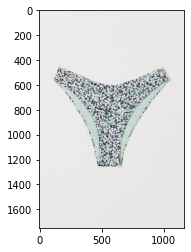

In [23]:
# This code displays the article (bikini bottom) that is used to for prediction 
import os
img = mpimg.imread(os.getcwd()+'\\photos\\'+str(bikini_bottom_id).zfill(10)+'.jpg')
imgplot = plt.imshow(img)
plt.show()

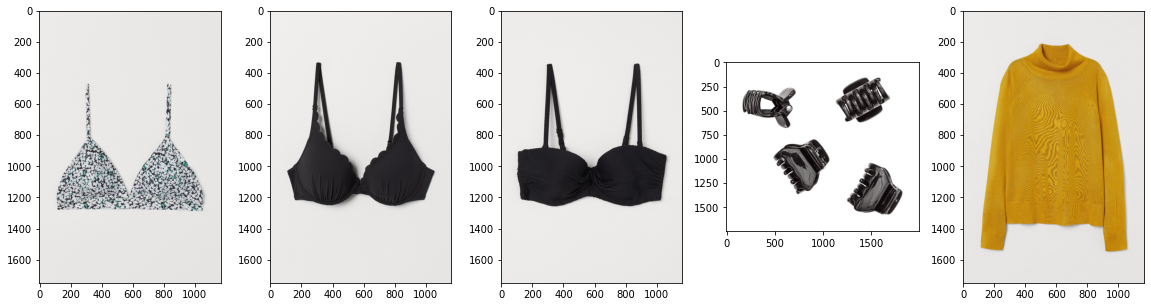

In [22]:
# These are the results for the prediction visualized.
article_ids = similar_items_detailed['article_id'].to_list()

fig = plt.figure(figsize=(20, 5))
columns = 5
rows = 1
for i in range(1, columns*rows +1):
    img = mpimg.imread(os.getcwd()+'\\photos\\'+str(article_ids[i-1]).zfill(10)+'.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

As we can see, the method shows promising results for this clothing item. It reccomends the matching bikini top and shows alternative tops that are usually bought. It also reccomends hair clips which surprisingly people buy as well while shopping for bikini bottoms. This method needs to be further investigated and evaluated before it can be implemented. It also needs more thinking on how it can be implented efficiently, but I think this is out of scope for this assingment.